# Iris Regression

> Vamos treinar uma regressão univariada usando redes neurais

> y e x serão selecionados via parâmetros

> a rede calculará uma função para aproximar a relação física entre os atributos da flor

> Primeiro vamos separar o conjunto de **treino** e **teste**. Vamos deixar 10 flores de cada classe como conjunto de teste (fora da amostra) 20% da base

> Depois vamos fazer uma **BUSCA EM GRID (GRIDSEARCH)** usando **VALIDAÇÃO CRUZADA ESTRATIFICADA**. Vamos deixar 10 flores como conjunto de validação 25%.


### Parâmetros

In [170]:
random_seed = 42
y_col = 'petallength'
x_cols = ['petalwidth', 'sepalwidth', 'sepallength']
my_activation = 'tanh'
test_size = 0.2
n_k_folds = 5
learning_rate = 0.01
my_loss = 'mse'
my_patience = 15
max_epochs = 150
n_neurons = 3

### Imports

In [171]:
import itertools
import pathlib

import keras
import numpy
import pandas
from matplotlib import pyplot
from seaborn import boxplot, kdeplot, pairplot
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

keras.utils.set_random_seed(random_seed)

### Data Understanding / Preparation

In [172]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent
path_to_iris = data_folder / 'datasets' / 'iris.data'
iris = pandas.read_csv(path_to_iris, sep=',', decimal='.')
iris.flower = [x[1] for x in iris.flower.str.split('-')]

iris

,sepallength,sepalwidth,petallength,petalwidth,flower
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


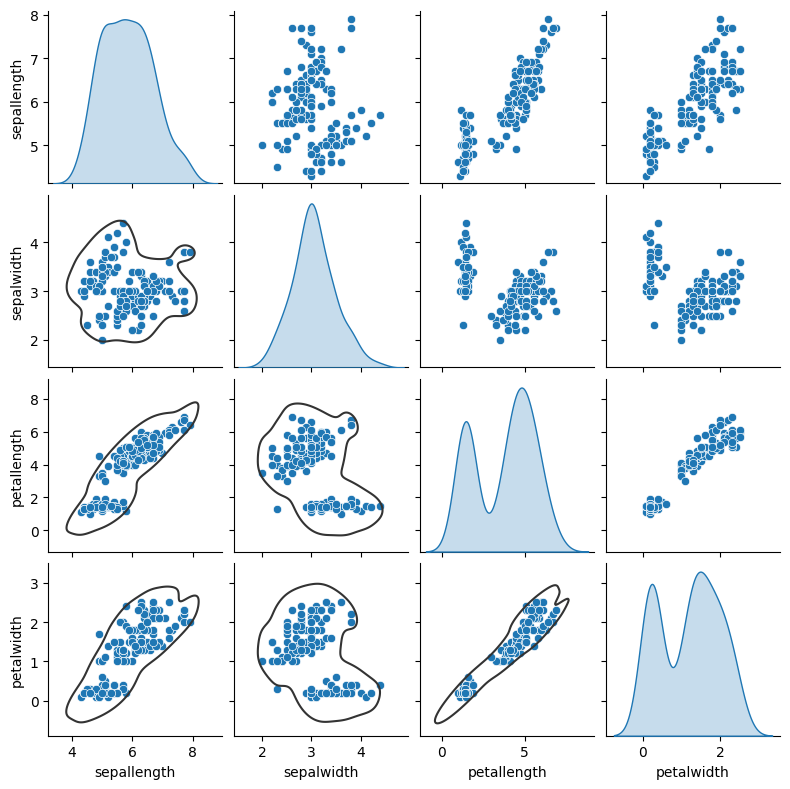

In [173]:
g = pairplot(iris, height=2.0, diag_kind='kde')
_ = g.map_lower(kdeplot, levels=1, color=".2")

### Data Preparation - Separar Treino e Validação

In [174]:
X = iris[x_cols]
y = iris[y_col].to_numpy().reshape(-1, 1)

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)

X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)

In [175]:
X_in, X_test, Y_in, Y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_seed)

# GET STRATIFIED FOLDS
kf = KFold(n_splits=n_k_folds, shuffle=True, random_state=random_seed)
kf.get_n_splits(X_in)

5

### Modeling - Construir a Rede

> Vamos iterar de 2 até n_neurons

> Vamos calcular a distribuição do R^2 de validação para cada hiperconfiguração

> Vamos criar um critério de parada de capacidade para a hiperconfiguração

> Vamos selecionar o melhor modelo dentro da melhor hiperconfiguração

> Vamos calcular o R^2 de teste do melhor modelo

> Vamos visualizar os gráficos de resultado do melhor modelo

In [176]:
results: list[dict] = []
for n_neuron in numpy.arange(1, n_neurons + 1):
    for ix_fold, (train_index, test_index) in enumerate(kf.split(X_in)):
        X_train, X_val = X_in[train_index], X_in[test_index]
        Y_train, Y_val = Y_in[train_index], Y_in[test_index]

        # TRAIN THE MODEL
        input_layer = keras.Input(shape=(len(x_cols),))
        hidden = keras.layers.Dense(n_neuron, activation=my_activation)(input_layer)
        output_layer = keras.layers.Dense(1, activation='linear')(hidden)
        model_name = f'N{n_neuron}F{ix_fold}'
        regression = keras.Model(inputs=input_layer, outputs=output_layer, name=model_name)
        regression.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss=my_loss)
        es_loss_val = keras.callbacks.EarlyStopping(monitor=f'val_loss', mode='min', patience=my_patience, restore_best_weights=True)
        history = regression.fit(X_train, Y_train, batch_size=X_scaled.shape[0], epochs=max_epochs, validation_data=(X_val, Y_val), callbacks=[es_loss_val], verbose=0)
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # CALCULATE TRAIN AND TEST R SQUARED
        Y_train_pred = regression.predict(X_train, verbose=0)
        Y_val_pred = regression.predict(X_val, verbose=0)

        train_r2 = r2_score(Y_train, Y_train_pred)
        val_r2 = r2_score(Y_val, Y_val_pred)

        # APPEND TRAINING RESULTS
        training_result = {
            'name': model_name,
            'n_neurons': n_neuron,
            'fold': ix_fold,
            'dataset': 'train',
            'r2': train_r2,
            'loss': val_r2,
            'model': regression,
            'history': history
        }
        results.append(training_result)

        # APPEND VALIDATION RESULTS
        validation_result = {
            'name': model_name,
            'n_neurons': n_neuron,
            'fold': ix_fold,
            'dataset': 'validation',
            'r2': val_r2,
            'loss': val_r2,
            'model': regression,
            'history': history
        }
        results.append(validation_result)
        print(f'{model_name}: train R2={100.0*train_r2:.1f}% val R2={100.0*val_r2:.1f}%')

results_df = pandas.DataFrame(results)

N1F0: train R2=96.7% val R2=97.5%
N1F1: train R2=97.6% val R2=94.9%
N1F2: train R2=96.5% val R2=98.9%
N1F3: train R2=96.2% val R2=96.0%
N1F4: train R2=97.3% val R2=96.9%
N2F0: train R2=97.2% val R2=96.4%
N2F1: train R2=97.2% val R2=94.4%
N2F2: train R2=96.6% val R2=98.9%
N2F3: train R2=97.7% val R2=96.4%
N2F4: train R2=97.8% val R2=97.7%
N3F0: train R2=97.9% val R2=97.4%
N3F1: train R2=98.1% val R2=96.4%
N3F2: train R2=97.5% val R2=99.0%
N3F3: train R2=97.3% val R2=96.2%
N3F4: train R2=97.5% val R2=96.4%


In [177]:
results_df

,name,n_neurons,fold,dataset,r2,loss,model,history
0,N1F0,1,0,train,0.967099,0.975112,"<Functional name=N1F0, built=True>",<keras.src.callbacks.history.History object at...
1,N1F0,1,0,validation,0.975112,0.975112,"<Functional name=N1F0, built=True>",<keras.src.callbacks.history.History object at...
2,N1F1,1,1,train,0.976454,0.949334,"<Functional name=N1F1, built=True>",<keras.src.callbacks.history.History object at...
3,N1F1,1,1,validation,0.949334,0.949334,"<Functional name=N1F1, built=True>",<keras.src.callbacks.history.History object at...
4,N1F2,1,2,train,0.964660,0.988797,"<Functional name=N1F2, built=True>",<keras.src.callbacks.history.History object at...
5,N1F2,1,2,validation,0.988797,0.988797,"<Functional name=N1F2, built=True>",<keras.src.callbacks.history.History object at...
6,N1F3,1,3,train,0.961805,0.960484,"<Functional name=N1F3, built=True>",<keras.src.callbacks.history.History object at...
7,N1F3,1,3,validation,0.960484,0.960484,"<Functional name=N1F3, built=True>",<keras.src.callbacks.history.History object at...
8,N1F4,1,4,train,0.972606,0.969333,"<Functional name=N1F4, built=True>",<keras.src.callbacks.history.History object at...
9,N1F4,1,4,validation,0.969333,0.969333,"<Functional name=N1F4, built=True>",<keras.src.callbacks.history.History object at...


In [178]:
results_boundaries = results_df.loc[results_df['dataset'] == 'validation'].groupby('n_neurons').agg({'r2': ['min', 'mean']})

results_boundaries.columns = ['_'.join(col).strip() for col in results_boundaries.columns.values]

results_boundaries = results_boundaries.reset_index()

results_boundaries.n_neurons -= 1

results_boundaries

,n_neurons,r2_min,r2_mean
0,0,0.949334,0.968612
1,1,0.944306,0.967892
2,2,0.961611,0.971026


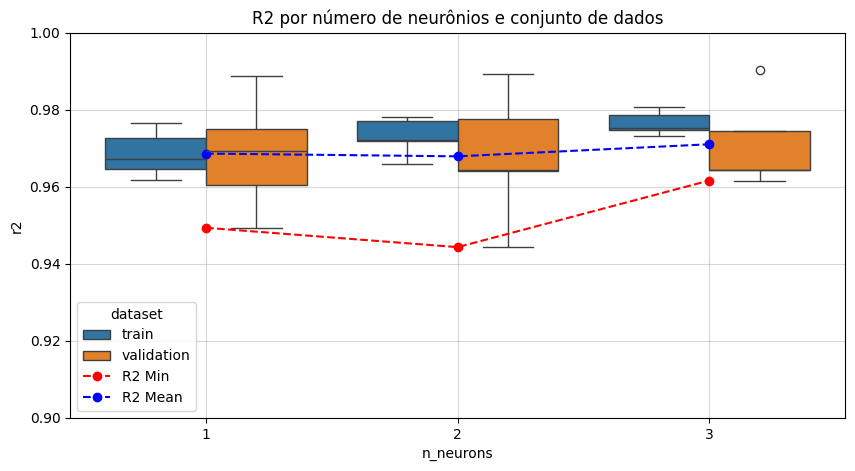

In [186]:
y_limits : float | tuple[float, float] | None = (0.9, 1.0)

fig = pyplot.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
boxplot(data=results_df, x='n_neurons', y='r2', hue='dataset', ax=ax)
_ = ax.set_title('R2 por número de neurônios e conjunto de dados')
_ = ax.grid(which='both', alpha=0.5)
_ = ax.set_ylim(y_limits)
_ = results_boundaries.plot(x='n_neurons', y='r2_min', ax=ax, color='red', marker='o', linestyle='--', label='R2 Min')
_ = results_boundaries.plot(x='n_neurons', y='r2_mean', ax=ax, color='blue', marker='o', linestyle='--', label='R2 Mean')
_ = ax.grid(which='both', alpha=0.5)

In [187]:
best_n_neurons = 3

In [188]:
best_row = results_df.loc[(results_df['n_neurons'] == best_n_neurons) & (results_df['dataset'] == 'validation')].sort_values(by='r2', ascending=False).head(1)

best_row

,name,n_neurons,fold,dataset,r2,loss,model,history
25,N3F2,3,2,validation,0.990406,0.990406,"<Functional name=N3F2, built=True>",<keras.src.callbacks.history.History object at...


In [189]:
best_model = best_row['model'].values[0]
best_history = best_row['history'].values[0]

### Convergência da Rede - Loss vs Val Loss

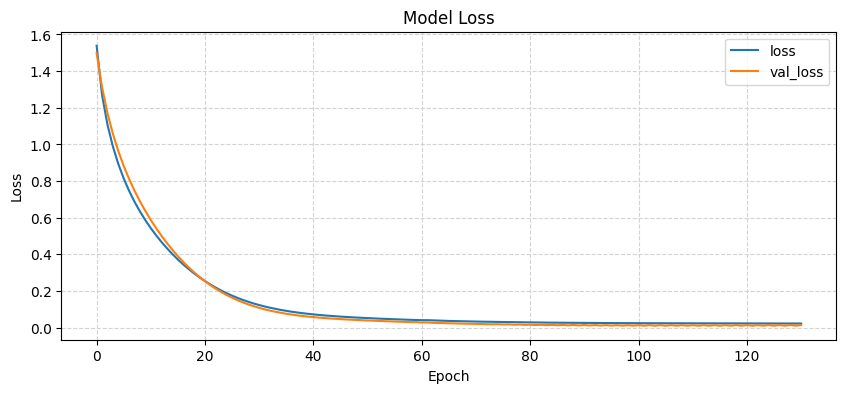

In [190]:
fig = pyplot.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(best_history.history['loss'], label='loss')
ax.plot(best_history.history['val_loss'], label='val_loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
_ = ax.legend()
ax.grid(which='both', color='lightgray', linestyle='--')

In [184]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
class_threshold = 0.5
little_delta = 0.1

In [185]:
x0_grid = numpy.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), grid_n_points)
x1_grid = numpy.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), grid_n_points)
x1_grid = numpy.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), grid_n_points)
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
Y_g = logistic_nn.predict(X_g)
Y_est = (logistic_nn.predict(X_scaled) > class_threshold).astype(int)
t_error, t_precision = logistic_nn.evaluate(X_scaled, y, verbose=0)

NameError: name 'logistic_nn' is not defined

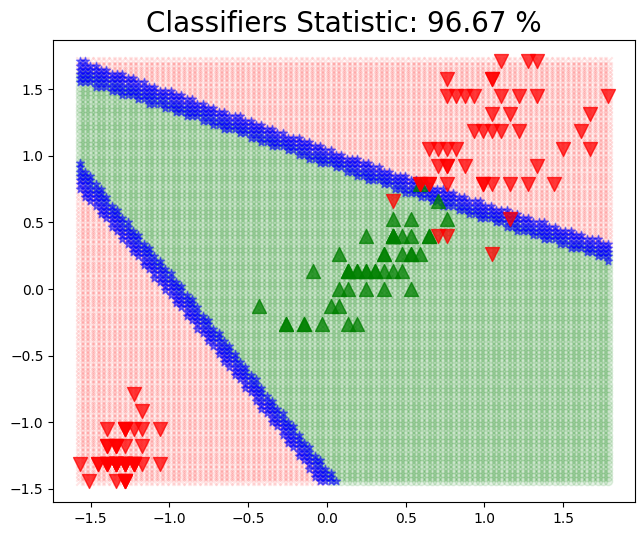

In [ ]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(7.5, 6.0))
ax = fig.add_subplot(111)
# PLOT CLASS REGION
ix_class_region = Y_g.reshape(-1) > class_threshold
ix_class_points = y.reshape(-1) == 1
ix_surface = (Y_g.reshape(-1) >= class_threshold - little_delta) &  (Y_g.reshape(-1) <= class_threshold + little_delta)
_ = ax.scatter(X_g[ix_class_region, 0], X_g[ix_class_region, 1], marker='o', color='green', alpha=0.1)
_ = ax.scatter(X_g[~ix_class_region, 0], X_g[~ix_class_region, 1], marker='x', color='red', alpha=0.1)
_ = ax.scatter(X_g[ix_surface, 0], X_g[ix_surface, 1], marker='*', color='blue', alpha=0.5)
_ = ax.scatter(X_scaled[ix_class_points, 0], X_scaled[ix_class_points, 1], marker='^', color='green', alpha=0.75, s=100)
_ = ax.scatter(X_scaled[~ix_class_points, 0], X_scaled[~ix_class_points, 1], marker='v', color='red', alpha=0.75, s=100)
_ = ax.set_title('Classifiers {}: {:.2f} %'.format('Statistic', 100*t_precision), size=20)